# Importação de bibliotecas


In [22]:
# %% [1] - Importação de bibliotecas
# ORIGINAL CODE
import os
import sys
import logging
from datetime import datetime
from pathlib import Path
from typing import Union, List, Dict, Optional, Any

project_root = Path().resolve().parent.parent
if project_root not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to Python path")

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

from src.analysis.diff_utils import (
    load_all_commit_jsonl,
    parse_patch_to_dataframe,
    CommitProcessor,
)
from src.analysis.diff_utils import MutationOperator as BaseMutationOperator
from src.analysis.diff_utils import MutationOperatorDetector as BaseMutationOperatorDetector


from src.analysis.config import get_config
config = get_config()



Added C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner to Python path


#  [2] - Definição de constantes e configurações

In [23]:
# Configuração de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("terraform_analysis.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("terraform_diff_analysis")

# Diretórios principais
BASE_DIR = Path(config['output_dir'])
DATASET_DIR = Path(config['dataset_dir'])
CHECKPOINT_DIR = Path(config['checkpoints_dir'])


COMMITS_DIR = BASE_DIR / "commits"
DIFFS_DIR = BASE_DIR / "diffs"
METRICS_DIR = BASE_DIR / "metrics"
VISUALIZATIONS_DIR = BASE_DIR / "visualizations"
ANALYSIS_DIR = BASE_DIR / "analysis"
OUTPUT_BASE_DIR = BASE_DIR / "output"

MAX_WORKERS = os.cpu_count() or 4  # Usa o número de CPUs disponíveis ou 4 como padrão
CHUNK_SIZE = 100  # Número de commits processados antes de salvar um checkpoint

for directory in [
    COMMITS_DIR, DIFFS_DIR, METRICS_DIR, 
    VISUALIZATIONS_DIR, ANALYSIS_DIR, CHECKPOINT_DIR, OUTPUT_BASE_DIR
]:
    directory.mkdir(parents=True, exist_ok=True)

# Versão do dataset - para controle de versões
DATASET_VERSION = datetime.now().strftime("%Y%m%d_%H%M%S")
VERSION_FILE = OUTPUT_BASE_DIR / "version.txt"



with open(VERSION_FILE, "w") as f:
    f.write(f"Version: {DATASET_VERSION}\n")
    f.write(f"Created: {datetime.now().isoformat()}\n")
    f.write(f"Base dataset: {DATASET_DIR}\n")

logger.info(f"Iniciando processamento versão {DATASET_VERSION}")

2025-04-25 23:27:59,434 - terraform_diff_analysis - INFO - Iniciando processamento versão 20250425_232759


In [24]:
class CommitAnalyzer:
    """
    Classe principal para análise de commits Terraform.
    
    Responsável por carregar, processar e analisar commits com foco em
    identificação de padrões de mudança para definição de operadores de mutação.
    """
    
    # Dicionário de categorias de mudanças agora é usado do diff_utils.py
    
    def __init__(self, dataset_dir: Union[str, Path], output_dir: Union[str, Path]):
        """
        Inicializa o analisador de commits.
        
        Parameters
        ----------
        dataset_dir : str ou Path
            Diretório contendo os dados a serem analisados
        output_dir : str ou Path
            Diretório base para salvar os resultados
        """
        self.dataset_dir = Path(dataset_dir)
        self.output_dir = Path(output_dir)
        self.commits = []
        self.resources = {}
        
        # Inicializar o processador de commits
        self.processor = CommitProcessor(
            dataset_dir=self.dataset_dir,
            output_dir=self.output_dir,
            checkpoint_dir=self.output_dir / "checkpoints"
        )
        
        logger.info(f"CommitAnalyzer inicializado. Dataset: {self.dataset_dir}, Output: {self.output_dir}")
        
    def load_all_commit_jsonl(self) -> List[dict]:
        """
        Percorre o diretório do dataset, encontra todos os arquivos .jsonl 
        e adiciona campo 'repo' a cada commit.
        
        Returns
        -------
        list
            Lista de dicionários contendo os dados de cada commit
        """
        # Utilizar a função importada de diff_utils
        self.commits = load_all_commit_jsonl(str(self.dataset_dir))
        return self.commits
        
    def analyze_commit(self, commit: dict) -> dict:
        """
        Analisa um commit individual, extraindo informações relevantes.
        
        Parameters
        ----------
        commit : dict
            Dicionário com informações do commit
            
        Returns
        -------
        dict
            Resultados da análise
        """
        repo = commit.get('repo', 'unknown')
        hash_ = commit.get('commit_hash', 'unknown')
        short_hash = hash_[:7] if hash_ else 'unknown'
        file = commit.get('file', '')
        patch = commit.get('patch', '')
        
        try:
            # Usa parse_patch_to_dataframe de diff_utils
            df = parse_patch_to_dataframe(patch)
            
            # Extrai métricas básicas
            added_lines = df[df['change'] == 'added'].shape[0]
            removed_lines = df[df['change'] == 'removed'].shape[0]
            context_lines = df[df['change'] == 'context'].shape[0]
            
            # Conta categorias de mudanças
            categories = df['category'].value_counts().to_dict()
            
            # Cria diretório para o repositório se não existir
            repo_dir = self.output_dir / "diffs" / repo
            repo_dir.mkdir(exist_ok=True, parents=True)
            
            # Salva o diff em CSV
            if not df.empty:
                csv_path = repo_dir / f"{short_hash}_{Path(file).stem}.csv"
                df.to_csv(csv_path, index=False, encoding='utf-8')
            
            # Resultados da análise
            results = {
                'repo': repo,
                'commit_hash': hash_,
                'short_hash': short_hash,
                'file': file,
                'diff_size': len(df),
                'added_lines': added_lines,
                'removed_lines': removed_lines,
                'context_lines': context_lines,
                'categories': categories,
                'output_path': str(csv_path) if not df.empty else None
            }
            
            return results
            
        except Exception as e:
            logger.error(f"Erro ao analisar commit {repo}/{short_hash}: {str(e)}")
            return {
                'repo': repo,
                'commit_hash': hash_,
                'short_hash': short_hash,
                'file': file,
                'error': str(e),
                'status': 'error'
            }
    
    def process_commits_parallel(self, resume: bool = True):
        """
        Processa commits em paralelo usando o CommitProcessor.
        
        Parameters
        ----------
        resume : bool, optional
            Se True, tenta retomar o processamento do último checkpoint
        """
        if not self.commits:
            self.load_all_commit_jsonl()
            
        if not self.commits:
            logger.warning("Nenhum commit para processar!")
            return
            
        results_df = self.processor.process_commits_parallel(
            commit_analyzer_func=self.analyze_commit,
            resume=resume,
            chunk_size=100
        )
        
        return results_df
    

    def generate_summary_report(self, results_df: pd.DataFrame = None) -> pd.DataFrame:
        """
        Gera relatório resumido das análises.
        
        Parameters
        ----------
        results_df : pd.DataFrame, optional
            DataFrame com resultados da análise. Se None, tenta carregar do disco.
            
        Returns
        -------
        pd.DataFrame
            DataFrame com resumo das análises
        """
        if results_df is None or results_df.empty:
            # Tenta carregar o arquivo mais recente
            analysis_files = list((self.output_dir / "analysis").glob("commit_analysis_*.csv"))
            if not analysis_files:
                logger.warning("Nenhum arquivo de análise encontrado!")
                return pd.DataFrame()
                
            latest = max(analysis_files, key=os.path.getmtime)
            logger.info(f"Carregando resultados de {latest}")
            results_df = pd.read_csv(latest)
        
        # Agrupa por repositório
        repo_summary = results_df.groupby('repo').agg({
            'commit_hash': 'nunique',
            'file': 'nunique',
            'diff_size': ['mean', 'sum'],
            'added_lines': ['mean', 'sum'],
            'removed_lines': ['mean', 'sum'],
        }).reset_index()
        
        # Renomeia colunas
        repo_summary.columns = [
            'repo', 'commits_count', 'files_count', 
            'avg_diff_size', 'total_diff_size',
            'avg_added_lines', 'total_added', 
            'avg_removed_lines', 'total_removed'
        ]
        
        # Calcula porcentagem de modificação (total added + removed / total diff size)
        repo_summary['change_percentage'] = (
            (repo_summary['total_added'] + repo_summary['total_removed']) / 
            repo_summary['total_diff_size'] * 100
        ).round(2)
        
        # Salva resumo
        metrics_dir = self.output_dir / "metrics"
        metrics_dir.mkdir(exist_ok=True, parents=True)
        version = datetime.now().strftime("%Y%m%d_%H%M%S")
        summary_path = metrics_dir / f"repo_summary_{version}.csv"
        repo_summary.to_csv(summary_path, index=False)
        
        logger.info(f"Resumo por repositório salvo em {summary_path}")
        return repo_summary

In [25]:
# %% [4] - Funções de análise estatística e visualização

def plot_commit_distribution(results_df: pd.DataFrame):
    """
    Gera gráfico de distribuição de commits por repositório.
    
    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame com resultados da análise
    """
    plt.figure(figsize=(12, 6))
    repo_counts = results_df['repo'].value_counts()
    
    # Gráfico de barras
    ax = sns.barplot(x=repo_counts.index, y=repo_counts.values)
    ax.set_title('Distribuição de Commits por Repositório')
    ax.set_xlabel('Repositório')
    ax.set_ylabel('Número de Commits')
    
    # Rotaciona labels para melhor visualização
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Salva figura
    plt.savefig(VISUALIZATIONS_DIR / 'commit_distribution.png', dpi=300)
    plt.show()

def plot_change_categories(results_df: pd.DataFrame):
    """
    Gera gráfico de categorias de mudanças.
    
    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame com resultados da análise
    """
    # Extrai categorias do DataFrame
    all_categories = {}
    
    for _, row in results_df.iterrows():
        categories = row.get('categories')
        if isinstance(categories, str):
            try:
                # Se for string, tenta converter para dict
                categories = eval(categories)
            except:
                continue
                
        if isinstance(categories, dict):
            for category, count in categories.items():
                all_categories[category] = all_categories.get(category, 0) + count
    
    if not all_categories:
        logger.warning("Nenhuma categoria encontrada para visualização")
        return
    
    # Cria DataFrame para visualização
    categories_df = pd.DataFrame([
        {'category': cat, 'count': count} 
        for cat, count in all_categories.items()
    ])
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='category', y='count', data=categories_df)
    ax.set_title('Distribuição de Categorias de Mudanças')
    ax.set_xlabel('Categoria')
    ax.set_ylabel('Contagem')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Salva figura
    plt.savefig(VISUALIZATIONS_DIR / 'change_categories.png', dpi=300)
    plt.show()

def calculate_correlation_matrix(results_df: pd.DataFrame):
    """
    Calcula matriz de correlação entre métricas.
    
    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame com resultados da análise
        
    Returns
    -------
    pd.DataFrame
        Matriz de correlação
    """
    # Seleciona apenas colunas numéricas
    numeric_cols = ['diff_size', 'added_lines', 'removed_lines']
    numeric_df = results_df[numeric_cols].copy()
    
    # Calcula correlação
    corr_matrix = numeric_df.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Matriz de Correlação entre Métricas')
    plt.tight_layout()
    
    # Salva figura
    plt.savefig(VISUALIZATIONS_DIR / 'correlation_matrix.png', dpi=300)
    plt.show()
    
    return corr_matrix

In [26]:
# %% [5] - Script principal de execução

def main(resume: bool = True, 
         max_workers: int = MAX_WORKERS, 
         visualize: bool = True,
         chunk_size: int = CHUNK_SIZE):
    """
    Função principal para executar o pipeline completo.
    
    Parameters
    ----------
    resume : bool, default=True
        Se True, tenta retomar o processamento do último checkpoint
    max_workers : int, default=MAX_WORKERS
        Número máximo de workers para processamento paralelo
    visualize : bool, default=True
        Se True, gera visualizações dos resultados
    chunk_size : int, default=CHUNK_SIZE
        Número de commits processados antes de salvar um checkpoint
        
    Returns
    -------
    dict
        Dicionário com os resultados da análise
    """
    logger.info("Iniciando pipeline de análise de commits Terraform")

    # Cria processador com número configurável de workers
    processor = CommitProcessor(
        dataset_dir=DATASET_DIR,
        output_dir=OUTPUT_BASE_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        max_workers=max_workers  # Usa o parâmetro max_workers
    )

    analyzer = CommitAnalyzer(DATASET_DIR, OUTPUT_BASE_DIR)

    # Carrega e processa commits usando o processador do diff_utils
    try:
        results_df = processor.process_commits_parallel(
            commit_analyzer_func=analyzer.analyze_commit,
            resume=resume,  # Usa o parâmetro resume
            chunk_size=chunk_size  # Usa o parâmetro chunk_size
        )
        
        if results_df.empty:
            logger.warning("Nenhum resultado obtido do processamento de commits.")
            return {'status': 'no_data'}
            
    except Exception as e:
        logger.error(f"Erro no processamento principal: {str(e)}")
        # Verificar se há algum checkpoint para recuperar dados parciais
        try:
            # Encontrar o checkpoint mais recente
            checkpoints = list(CHECKPOINT_DIR.glob("checkpoint_*.json"))
            if checkpoints:
                logger.info("Tentando recuperar dados do último checkpoint")
                latest = max(checkpoints, key=os.path.getmtime)
                # Carregar resultados salvos previamente se existirem
                analysis_files = list(ANALYSIS_DIR.glob("commit_analysis_*.csv"))
                if analysis_files:
                    latest_analysis = max(analysis_files, key=os.path.getmtime)
                    logger.info(f"Carregando resultados parciais de {latest_analysis}")
                    results_df = pd.read_csv(latest_analysis)
                else:
                    logger.error("Não foi possível recuperar resultados. Pipeline abortado.")
                    return {'status': 'error', 'error': str(e)}
            else:
                logger.error("Nenhum checkpoint encontrado. Pipeline abortado.")
                return {'status': 'error', 'error': str(e)}
        except Exception as recovery_error:
            logger.error(f"Erro na recuperação: {str(recovery_error)}")
            return {'status': 'error', 'error': str(e)}

    # Gera relatório resumido
    summary_df = analyzer.generate_summary_report(results_df)

    # Gera visualizações apenas se solicitado
    if visualize:
        plot_commit_distribution(results_df)
        plot_change_categories(results_df)
        correlation_matrix = calculate_correlation_matrix(results_df)
    else:
        logger.info("Visualizações desabilitadas. Ignorando geração de gráficos.")
        correlation_matrix = None

    logger.info("Pipeline de análise concluído com sucesso!")

    # Exibe resultados apenas se houver dados para visualizar
    if not results_df.empty and not summary_df.empty:
        display(Markdown("## Resumo da Análise"))
        display(summary_df)

    return {
        'status': 'success',
        'analyzer': analyzer,
        'results': results_df,
        'summary': summary_df,
        'correlation': correlation_matrix
    }

In [27]:
# %% [6] - Classes e métodos para categorização de operadores de mutação


MutationOperator = BaseMutationOperator

class MutationOperatorDetector(BaseMutationOperatorDetector):
    """
    Detector de operadores de mutação potenciais em diffs Terraform.
    Estende a implementação base com métodos para análise e visualização.
    """
    
    def analyze_repository_diffs(self, repo: str) -> Dict[str, int]:
        """
        Analisa todos os diffs de um repositório para detectar operadores.
        
        Parameters
        ----------
        repo : str
            Nome do repositório
            
        Returns
        -------
        dict
            Dicionário com contagem de operadores no repositório
        """
        # Implementação mantida no notebook, pois lida com análise específica
        # usando caminhos e estruturas definidas no notebook (DIFFS_DIR)
        repo_dir = DIFFS_DIR / repo
        if not repo_dir.exists():
            logger.warning(f"Diretório do repositório não encontrado: {repo_dir}")
            return {}
            
        all_counts = {op_name: 0 for op_name in self.operators}
        
        for csv_file in repo_dir.glob("*.csv"):
            try:
                diff_df = pd.read_csv(csv_file)
                counts = self.detect_potential_operators(diff_df)
                
                for op_name, count in counts.items():
                    all_counts[op_name] += count
                    
            except Exception as e:
                logger.error(f"Erro ao analisar {csv_file}: {str(e)}")
                
        # Remove operadores sem ocorrências
        return {k: v for k, v in all_counts.items() if v > 0}
    
    # O restante dos métodos específicos para análise e visualização 
    # se mantêm no notebook (analyze_all_repositories, plot_operator_distribution)

    def analyze_all_repositories(self) -> pd.DataFrame:
        """
        Analisa todos os repositórios para identificar operadores de mutação.
        
        Returns
        -------
        pd.DataFrame
            DataFrame com contagem de operadores por repositório
        """
        repos = [d.name for d in DIFFS_DIR.iterdir() if d.is_dir()]
        logger.info(f"Analisando operadores em {len(repos)} repositórios")
        
        results = []
        
        for repo in tqdm(repos, desc="Analisando repositórios"):
            counts = self.analyze_repository_diffs(repo)
            
            # Se encontrou algum operador
            if counts:
                counts['repo'] = repo
                results.append(counts)
                
        # Cria DataFrame
        if not results:
            return pd.DataFrame()
            
        result_df = pd.DataFrame(results)
        result_df.fillna(0, inplace=True)
        
        # Calcula totais
        result_df['total_operators'] = result_df.drop('repo', axis=1).sum(axis=1)
        
        # Salva resultados
        output_path = ANALYSIS_DIR / f"mutation_operators_{DATASET_VERSION}.csv"
        result_df.to_csv(output_path, index=False)
        
        logger.info(f"Análise de operadores salva em {output_path}")
        return result_df
        
    def plot_operator_distribution(self, result_df: pd.DataFrame = None):
        """
        Visualiza a distribuição de operadores de mutação.
        
        Parameters
        ----------
        result_df : pd.DataFrame, optional
            DataFrame com contagem de operadores. Se None, tenta carregar do disco.
        """
        if result_df.empty:
            analysis_files = list(ANALYSIS_DIR.glob("mutation_operators_*.csv"))
            if not analysis_files:
                logger.warning("Nenhum arquivo de análise de operadores encontrado!")
                return
                
            latest = max(analysis_files, key=os.path.getmtime)
            logger.info(f"Carregando resultados de {latest}")
            result_df = pd.read_csv(latest)
        
        if 'repo' not in result_df.columns:
            logger.warning("DataFrame não contém coluna 'repo'")
            return
            
        # Cria DataFrame de totais por operador
        op_cols = [col for col in result_df.columns if col != 'repo' and col != 'total_operators']
        op_totals = result_df[op_cols].sum().reset_index()
        op_totals.columns = ['operator', 'count']
        op_totals = op_totals.sort_values('count', ascending=False)
        
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='operator', y='count', data=op_totals)
        ax.set_title('Distribuição de Operadores de Mutação')
        ax.set_xlabel('Operador')
        ax.set_ylabel('Contagem')
        
        # Rotaciona labels para melhor visualização
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Salva figura
        plt.savefig(VISUALIZATIONS_DIR / 'operator_distribution.png', dpi=300)
        plt.show()
        
        # Gera também heatmap por repositório
        if len(result_df) > 1:
            plt.figure(figsize=(14, 8))
            
            # Pivota o DataFrame para formato adequado
            pivot_df = result_df.set_index('repo')[op_cols]
            
            # Normaliza para melhor visualização
            if not pivot_df.empty:
                pivot_norm = pivot_df.div(pivot_df.max(axis=1), axis=0)
                sns.heatmap(pivot_norm, cmap='YlGnBu', annot=pivot_df, fmt='.0f')
                plt.title('Heatmap de Operadores por Repositório')
                plt.tight_layout()
                
                # Salva figura
                plt.savefig(VISUALIZATIONS_DIR / 'operator_heatmap.png', dpi=300)
                plt.show()

In [28]:
# %% [7] - Execução do detector de operadores
def analyze_mutation_operators():
    """Executa análise de operadores de mutação nos diffs."""
    logger.info("Iniciando análise de operadores de mutação")
    
    # Usar a classe MutationOperatorDetector de diff_utils.py como base
    detector = MutationOperatorDetector()  # Já estendida com métodos de análise e visualização
    
    # Como a função analyze_all_repositories() foi mantida na classe estendida,
    # podemos chamá-la normalmente
    result_df = detector.analyze_all_repositories()
    
    if not result_df.empty:
        # Essa função de visualização também permanece na classe estendida
        detector.plot_operator_distribution(result_df)
        
        # O restante da função permanece inalterado
        # Exibe resultados
        display(Markdown("## Operadores de Mutação Detectados"))
        display(result_df)
        
        # Salva relatório detalhado em HTML
        html_path = ANALYSIS_DIR / f"mutation_operators_report_{DATASET_VERSION}.html"
        with open(html_path, 'w') as f:
            f.write("<html><body>")
            f.write("<h1>Relatório de Operadores de Mutação Terraform</h1>")
            f.write(f"<p>Data de geração: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>")
            f.write("<h2>Operadores por Repositório</h2>")
            f.write(result_df.to_html(index=False, escape=False))
            
            # Adiciona descrição de operadores
            f.write("<h2>Descrição dos Operadores</h2>")
            f.write("<table border='1'>")
            f.write("<tr><th>Operador</th><th>Descrição</th><th>Categoria</th></tr>")
            
            for op_name, op in detector.operators.items():
                if op_name in result_df.columns:
                    f.write(f"<tr><td>{op_name}</td><td>{op.description}</td><td>{op.category}</td></tr>")
            
            f.write("</table>")
            f.write("</body></html>")
            
        logger.info(f"Relatório detalhado salvo em {html_path}")
    else:
        logger.warning("Nenhum operador de mutação detectado nos diffs analisados")
    
    return detector, result_df

2025-04-25 23:27:59,643 - terraform_diff_analysis - INFO - Iniciando pipeline de análise de commits Terraform
2025-04-25 23:27:59,644 - terraform_diff_utils - INFO - CommitProcessor initialized. Dataset: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\dataset, Output: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\reports\output
2025-04-25 23:27:59,645 - terraform_diff_utils - INFO - CommitProcessor initialized. Dataset: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\dataset, Output: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\reports\output
2025-04-25 23:27:59,645 - terraform_diff_analysis - INFO - CommitAnalyzer inicializado. Dataset: C:\Users\asu\OneDrive\Study\University\St

Analyzing commits:   0%|          | 0/21524 [00:00<?, ?it/s]

2025-04-25 23:28:00,483 - terraform_diff_utils - INFO - Checkpoint saved: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\checkpoints\checkpoint_20250425_232759_100.json (100 commits processed)
2025-04-25 23:28:00,660 - terraform_diff_utils - INFO - Checkpoint saved: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\checkpoints\checkpoint_20250425_232759_200.json (200 commits processed)
2025-04-25 23:28:00,826 - terraform_diff_utils - INFO - Checkpoint saved: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\checkpoints\checkpoint_20250425_232759_300.json (300 commits processed)
2025-04-25 23:28:00,990 - terraform_diff_utils - INFO - Checkpoint saved: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform

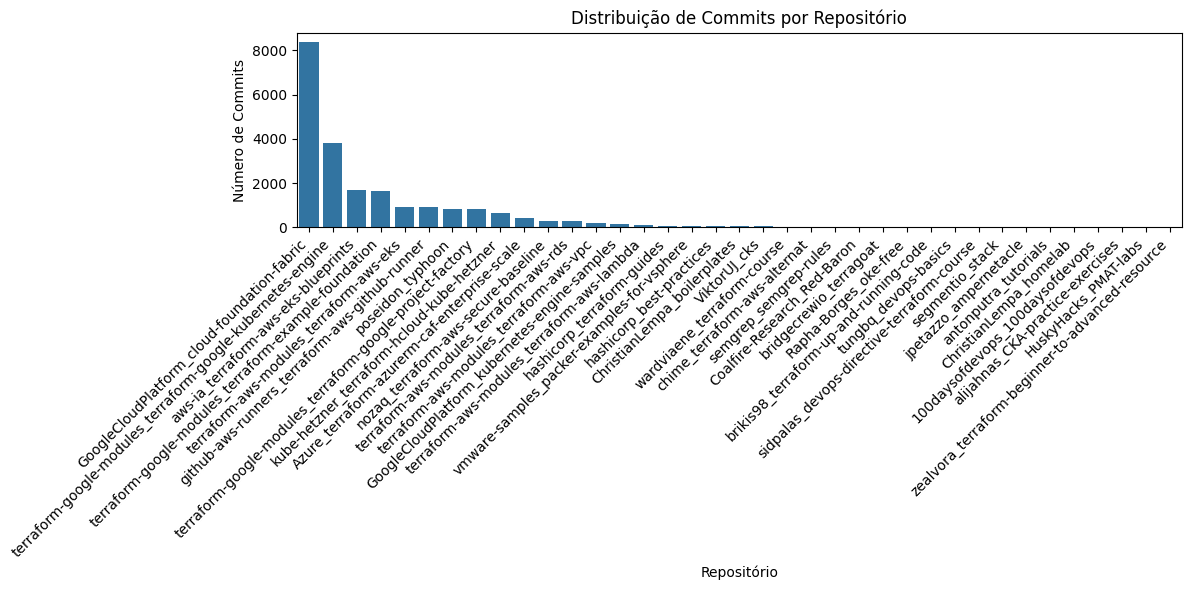

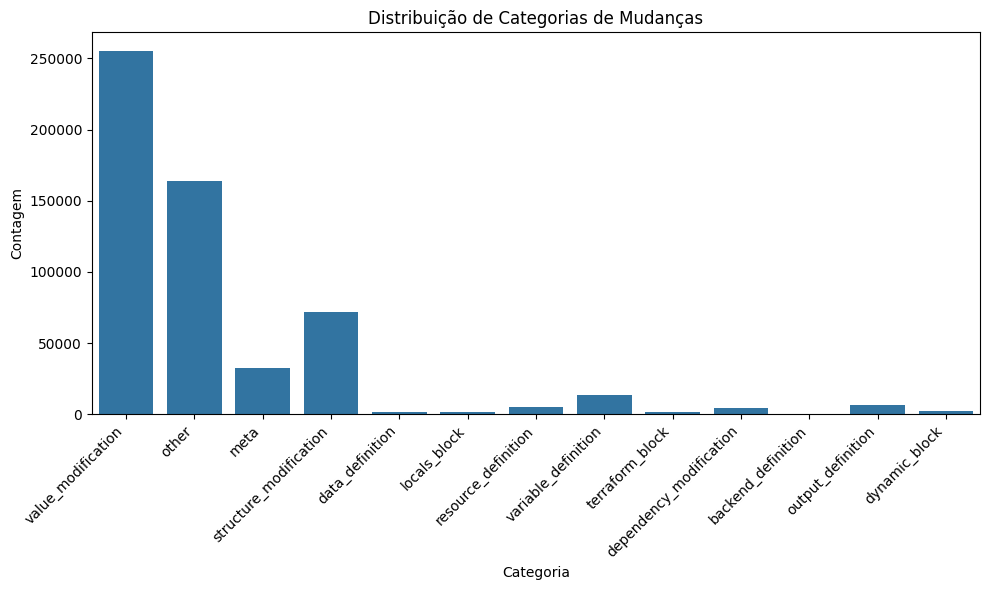

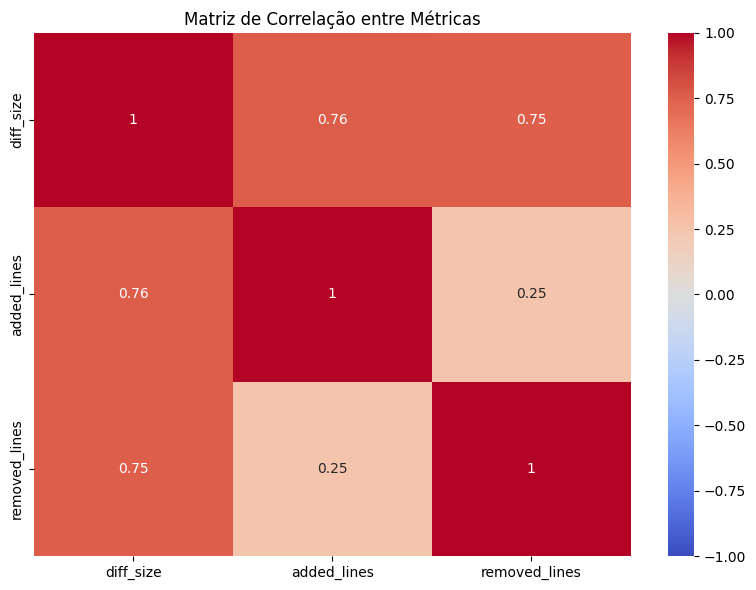

2025-04-25 23:28:41,518 - terraform_diff_analysis - INFO - Pipeline de análise concluído com sucesso!


## Resumo da Análise

,repo,commits_count,files_count,avg_diff_size,total_diff_size,avg_added_lines,total_added,avg_removed_lines,total_removed,change_percentage
0,100daysofdevops_100daysofdevops,2,2,14.000000,28,3.000000,6,3.000000,6,42.86
1,Azure_terraform-azurerm-caf-enterprise-scale,98,102,34.727941,14169,6.500000,2652,14.176471,5784,59.54
2,ChristianLempa_boilerplates,5,15,7.097561,291,1.024390,42,1.000000,41,28.52
3,ChristianLempa_homelab,3,2,29.333333,88,5.333333,16,5.666667,17,37.50
4,Coalfire-Research_Red-Baron,7,21,10.695652,246,1.347826,31,1.608696,37,27.64
5,GoogleCloudPlatform_cloud-foundation-fabric,1141,1756,28.231302,236296,9.051374,75760,6.609797,55324,55.47
6,GoogleCloudPlatform_kubernetes-engine-samples,22,93,20.391304,2814,6.630435,915,6.079710,839,62.33
7,HuskyHacks_PMAT-labs,1,2,15.000000,30,1.000000,2,3.500000,7,30.00
8,Rapha-Borges_oke-free,9,5,15.500000,279,2.666667,48,3.722222,67,41.22
9,ViktorUJ_cks,6,28,22.368421,850,6.131579,233,7.657895,291,61.65



Pipeline completo para análise de diffs Terraform e detecção de operadores de mutação.

Para executar a análise:
1. Execute 'results = main()' para processar todos os commits
2. Execute 'detector, operator_df = analyze_mutation_operators()' para analisar operadores

Todos os resultados serão salvos no diretório 'reports/' com a seguinte estrutura:
- commits/: Informações sobre cada commit
- diffs/: DataFrames dos diffs processados
- metrics/: Métricas e estatísticas calculadas
- visualizations/: Gráficos e visualizações geradas
- analysis/: Relatórios de análise consolidados



In [29]:
# %% [8] - Exemplo de uso da pipline completa

# Executa o pipeline completo
results = main(resume=False)

# Após processar os dados, analisa operadores de mutação
# detector, operator_df = analyze_mutation_operators()

# Exibe conclusão
print("""
Pipeline completo para análise de diffs Terraform e detecção de operadores de mutação.

Para executar a análise:
1. Execute 'results = main()' para processar todos os commits
2. Execute 'detector, operator_df = analyze_mutation_operators()' para analisar operadores

Todos os resultados serão salvos no diretório 'reports/' com a seguinte estrutura:
- commits/: Informações sobre cada commit
- diffs/: DataFrames dos diffs processados
- metrics/: Métricas e estatísticas calculadas
- visualizations/: Gráficos e visualizações geradas
- analysis/: Relatórios de análise consolidados
""")

In [30]:
# %% [9] - Exemplos interativos de uso

def demonstrate_commit_analysis():
    """Demonstração interativa da análise de um único commit."""
    
    # Carregar um commit de exemplo
    try:
        commits = load_all_commit_jsonl(str(DATASET_DIR))
        if not commits:
            print("Nenhum commit encontrado no dataset.")
            return
            
        # Pegar o primeiro commit para demonstração
        example_commit = commits[0]
        
        # Mostrar informações básicas
        print(f"Analisando commit: {example_commit.get('commit_hash')}")
        print(f"Repositório: {example_commit.get('repo')}")
        print(f"Arquivo: {example_commit.get('file')}")
        
        # Criar analisador
        analyzer = CommitAnalyzer(DATASET_DIR, OUTPUT_BASE_DIR)
        
        # Analisar o commit
        result = analyzer.analyze_commit(example_commit)
        
        # Exibir resultados
        display(Markdown("### Resultado da Análise"))
        display(pd.DataFrame([result]))
        
        # Se tiver patch, mostrar o processamento
        if 'patch' in example_commit and example_commit['patch']:
            display(Markdown("### Processamento do Patch"))
            df = parse_patch_to_dataframe(example_commit['patch'])
            
            # Mostrar as primeiras linhas
            display(Markdown("#### DataFrame do Patch (primeiras 10 linhas)"))
            display(df.head(10))
            
            # Contagem por tipo de mudança
            display(Markdown("#### Contagem por Tipo de Mudança"))
            display(df['change'].value_counts())
            
            # Contagem por categoria
            display(Markdown("#### Contagem por Categoria"))
            display(df['category'].value_counts())
            
            # Verificar operadores potenciais
            display(Markdown("### Operadores de Mutação Potenciais"))
            detector = MutationOperatorDetector()
            operators = detector.detect_potential_operators(df)
            
            if operators:
                display(pd.DataFrame([operators]))
            else:
                print("Nenhum operador de mutação detectado neste commit.")
        
    except Exception as e:
        print(f"Erro na demonstração: {str(e)}")

# Para executar a demonstração, descomente a linha abaixo
# demonstrate_commit_analysis()